In [63]:
import pandas as pd
from pathlib import Path
import glob

time_column: str = "Time"

def read_satellite_data(path: Path, threshold: float = 0.1) -> pd.DataFrame:
    all_files = glob.glob(f"{path}/*.csv")
    df = (
        pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
        .groupby(time_column, as_index=False)
        .mean()
    )
    df[time_column] = pd.to_datetime(df[time_column]).dt.normalize()

    min_non_null = int(threshold * len(df))
    
    df = df.loc[:, df.notnull().sum() >= min_non_null]

    return df


satellite_data = read_satellite_data("../data/satellites/amicalsat")

print(satellite_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  3655 non-null   datetime64[ns]
 1   Battery Voltage (from Main EPS)       940 non-null    float64       
 2   Battery Voltage (from Redundant EPS)  1061 non-null   float64       
 3   Solar Panel Voltage (main EPS)        940 non-null    float64       
 4   V Solar Voltage (redundant EPS)       1033 non-null   float64       
 5   V Solar Voltage (main EPS)            1030 non-null   float64       
 6   Solar Panel Voltage (redundant EPS)   1061 non-null   float64       
 7   I In (main EPS)                       1030 non-null   float64       
 8   Input Current (main EPS)              940 non-null    float64       
 9   I In (redundant EPS)                  1033 non-null   float64       
 10  

In [65]:
def read_solar_data(file_path: Path, date_column: str) -> pd.DataFrame:
    df = pd.read_json(file_path)
    df[date_column] = pd.to_datetime(df[date_column])
    return df


swpc_observed_ssn = read_solar_data(
    "../data/solar/swpc/swpc_observed_ssn.json", "Obsdate"
)
print(swpc_observed_ssn.info())

swpc_observed_solar_cycle_indicies = read_solar_data(
    "../data/solar/swpc/observed-solar-cycle-indices.json", "time-tag"
)
print(swpc_observed_solar_cycle_indicies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9137 entries, 0 to 9136
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Obsdate   9137 non-null   datetime64[ns]
 1   swpc_ssn  9137 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 142.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time-tag           3309 non-null   datetime64[ns]
 1   ssn                3309 non-null   float64       
 2   smoothed_ssn       3309 non-null   float64       
 3   observed_swpc_ssn  3309 non-null   float64       
 4   smoothed_swpc_ssn  3309 non-null   float64       
 5   f10.7              3309 non-null   float64       
 6   smoothed_f10.7     3309 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory 

In [102]:
dynamics = pd.merge(
    satellite_data, swpc_observed_ssn, left_on="Time", right_on="Obsdate", how="left"
).drop(columns=["Obsdate"])

dynamics = pd.merge(
    dynamics,
    swpc_observed_solar_cycle_indicies,
    left_on="Time",
    right_on="time-tag",
    how="left",
).drop(columns=["time-tag"])

print(dynamics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  3655 non-null   datetime64[ns]
 1   Battery Voltage (from Main EPS)       940 non-null    float64       
 2   Battery Voltage (from Redundant EPS)  1061 non-null   float64       
 3   Solar Panel Voltage (main EPS)        940 non-null    float64       
 4   V Solar Voltage (redundant EPS)       1033 non-null   float64       
 5   V Solar Voltage (main EPS)            1030 non-null   float64       
 6   Solar Panel Voltage (redundant EPS)   1061 non-null   float64       
 7   I In (main EPS)                       1030 non-null   float64       
 8   Input Current (main EPS)              940 non-null    float64       
 9   I In (redundant EPS)                  1033 non-null   float64       
 10  

In [105]:
import plotly.graph_objects as go


def plot_general_dynamic(df: pd.DataFrame) -> None:
    fig = go.Figure()

    columns: list[str] = [f"{column}" for column in df.columns if column != "Time"]

    for column in columns:
        fig.add_trace(
            go.Scatter(
                x=df["Time"],
                y=df[column],
                mode="lines",
                name=column,
                hoverinfo="text",
                text=column,
            )
        )

    fig.update_layout(
        title="Dynamics of Solar Parameters and Lightsail Values Over Time",
        title_x=0.5,
        title_y=0.01,
        xaxis_title="Time",
        yaxis_title="Values",
        xaxis_tickangle=-45,
        legend=dict(
            title="Parameters",
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1,
            itemsizing="constant",
        ),
        template="plotly_white",
        margin=dict(l=40, r=40, t=40, b=100),
    )

    fig.show()


def get_normalized_dataframe(df: pd.DataFrame, exclude_column: str) -> pd.DataFrame:
    columns_to_normalize = df.columns[df.columns != exclude_column]

    normalized_df = df.copy()

    normalized_df[columns_to_normalize] = (
        df[columns_to_normalize] - df[columns_to_normalize].mean()
    ) / df[columns_to_normalize].std()

    return normalized_df


normalized_dynamics = get_normalized_dataframe(dynamics, exclude_column="Time")

plot_general_dynamic(normalized_dynamics)

# Dependency Graph Based on Highest Correlation

In this analysis, we compute the correlation between different variables in a dataset and visualize the relationships using a dependency graph. The following mathematical concepts are involved in this process:

## 1. Correlation Coefficient

The correlation coefficient quantifies the degree to which two variables are related. It is calculated using the formula:

$$
r_{xy} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$


Where:
- $r_{xy}$ is the correlation coefficient between variables $X$ and $Y$.
- $\text{Cov}(X, Y)$ is the covariance between $X$ and $Y$.
- $\sigma_X$ is the standard deviation of variable $X$.
- $\sigma_Y$ is the standard deviation of variable $Y$.

## 2. Covariance

Covariance measures how much two random variables vary together. It is defined as:

$$
\text{Cov}(X, Y) = E\left[(X - E[X])(Y - E[Y])\right]
$$


Where:
- $E[X]$ is the expected value (mean) of $X$.
- $E[Y]$ is the expected value (mean) of $Y$.

## 3. Maximum Correlation

For each variable in the dataset, we find the variable with which it has the highest correlation. This is represented mathematically as:

$$
\text{max\_corr}(X) = \arg\max_{Y} r_{XY}
$$


Where:
- $X$ is a variable from the dataset.
- $Y$ represents all other variables in the dataset.
- $r_{XY}$ is the correlation coefficient between $X$ and $Y$.

## 4. Graph Representation

The relationships are represented as a graph where:
- Each node represents a variable.
- Each edge represents a relationship based on maximum correlation.

### Nodes
Each unique variable is added as a node:

$$
\text{nodes} = \{ "name": X, "name": Y, ...\}
$$


### Edges
An edge is created from each variable to its maximum correlated variable:

$$
\text{edges} = \{ "source": X, "target": Y\}
$$


## Conclusion

The resulting graph visualizes how each variable relates to its most correlated counterpart, providing insights into dependencies within the dataset.


In [109]:
import pandas as pd
from pyecharts import options as opts
from pyecharts.charts import Graph


def render_dependency_graph(df: pd.DataFrame, top_n: int = 5) -> Graph:
    nodes: Graph.Sequence[Graph.GraphNode] = []
    edges: Graph.Sequence[Graph.GraphLink] = []

    correlation_matrix = df.corr()

    for column in df.columns:
        correlations = correlation_matrix[column].drop(column).dropna()

        if not correlations.empty:
            top_correlations = correlations.nlargest(top_n)

            for _, (corr_col, corr_value) in enumerate(top_correlations.items()):
                if {"name": column} not in nodes:
                    nodes.append({"name": column})
                if {"name": corr_col} not in nodes:
                    nodes.append({"name": corr_col})

                edges.append({"source": column, "target": corr_col, "value": corr_value})

    return (
        Graph()
        .add("", nodes=nodes, links=edges, layout="circular", is_rotate_label=True)
        .set_global_opts(
            title_opts=opts.TitleOpts(
                title="Dependency Graph Based on Highest Correlations"
            ),
            tooltip_opts=opts.TooltipOpts(trigger="item", formatter="{c}"),
        )
    )

render_dependency_graph(normalized_dynamics, top_n=5).render_notebook()

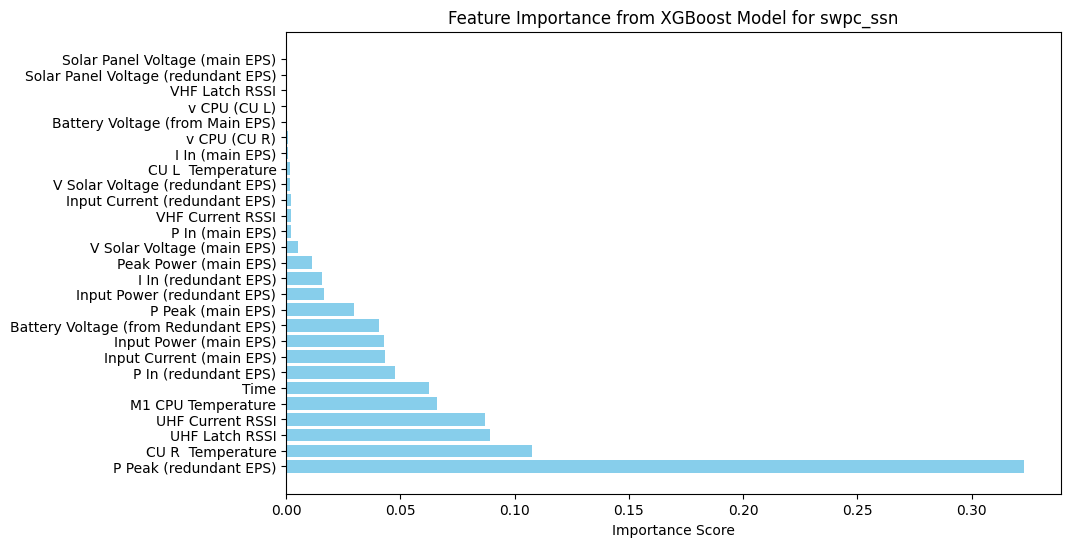

In [125]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

solar_columns: list[str] = (
    swpc_observed_ssn.columns.drop("Obsdate").tolist()
    + swpc_observed_solar_cycle_indicies.columns.drop("time-tag").tolist()
)

dynamics_cleaned = normalized_dynamics.dropna(subset=solar_columns)
print(dynamics_cleaned.info)

for col in dynamics_cleaned.select_dtypes(include=["datetime64[ns]"]).columns:
    dynamics_cleaned[col] = dynamics_cleaned[col].astype("int64") // 10**9

X = dynamics_cleaned.drop(solar_columns, axis=1)
target_column = solar_columns[0]
y = dynamics_cleaned[target_column]

for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].astype("category")

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = XGBRegressor(enable_categorical=True)
model.fit(X_train, y_train)


importance = model.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})

feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)


plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df["Feature"],
    feature_importance_df["Importance"],
    color="skyblue",
)
plt.xlabel("Importance Score")
plt.title(f"Feature Importance from XGBoost Model for {target_column}")
plt.show()

In [121]:
nodes = [{"name": row['Feature'], "value": row['Importance']} for _, row in feature_importance_df.iterrows()]
links = []

for i in range(1, len(nodes)):
    links.append({"source": nodes[i-1]['name'], "target": nodes[i]['name']})

graph = (
    Graph()
    .add("", nodes, links)
    .set_global_opts(title_opts=opts.TitleOpts(title="Feature Importance Dependency Graph"))
)

graph.render_notebook()

In [43]:
def print_correlations(df: pd.DataFrame, target_column: str) -> None:
    methods: list[str] = ["pearson", "kendall", "spearman"]

    for method in methods:
        correlations = (
            df.corr(method=method)
            .drop("Time")[target_column]
            .sort_values(ascending=False)
            .dropna()
        )
        print(f"Correlations using {method}:\n{correlations}\n")

for solar_column in solar_columns:
    print_correlations(dynamics, solar_column)

Correlations using pearson:
swpc_ssn                                1.000000
f10.7                                   0.848004
observed_swpc_ssn                       0.833923
ssn                                     0.832100
boot count                              0.747477
P Peak (redundant EPS)                  0.534172
smoothed_swpc_ssn                       0.437341
smoothed_ssn                            0.434102
P In (redundant EPS)                    0.375368
Solar Panel Voltage (main EPS)          0.316641
Solar Panel Voltage (redundant EPS)     0.297435
UHF Current RSSI                        0.266736
I In (redundant EPS)                    0.265890
smoothed_f10.7                          0.166023
Input Power (redundant EPS)             0.163042
Input Current (redundant EPS)           0.147065
Peak Power (main EPS)                   0.145628
M1 CPU Temperature                      0.138032
UHF Latch RSSI                          0.119963
CU R  Temperature                       0

# Statistical Analysis Interpretation

In statistical analysis, particularly when examining the relationship between two variables, several key metrics provide insights into the nature and strength of that relationship. Here’s a breakdown of these metrics:

## 1. Correlation Coefficient
- **Definition**: The correlation coefficient quantifies the degree to which two variables are related.
- **Interpretation**:
  - A value close to **+1** indicates a strong positive correlation (as one variable increases, the other tends to increase).
  - A value close to **-1** indicates a strong negative correlation (as one variable increases, the other tends to decrease).
  - A value around **0** suggests little to no linear relationship.

## 2. Regression Equation
- **Definition**: The regression equation represents the fitted line from the regression analysis.
- **Form**: 
  $$
  y = b_0 + b_1x
  $$
  Where:
  - \(y\) is the dependent variable.
  - \(b_0\) is the intercept (expected value of \(y\) when \(x = 0\)).
  - \(b_1\) is the slope (change in \(y\) for a one-unit increase in \(x\)).
- **Interpretation**: The slope indicates how much change in the dependent variable is expected for each unit change in the independent variable.

## 3. R-squared (R²)
- **Definition**: R-squared measures how well the independent variable(s) explain the variability of the dependent variable.
- **Interpretation**:
  - An R² value close to **1** means that a large proportion of the variance in \(y\) can be explained by changes in \(x\).
  - An R² value close to **0** indicates that changes in \(x\) do not explain much of the variance in \(y\).

## 4. Standard Error of the Slope
- **Definition**: This statistic provides an estimate of how much variability exists in the slope estimate.
- **Interpretation**: A smaller standard error relative to the slope suggests greater confidence in the slope estimate.

## 5. P-value
- **Definition**: The p-value tests the null hypothesis that there is no relationship between the independent and dependent variables.
- **Interpretation**:
  - A small p-value (typically < 0.05) suggests strong evidence against the null hypothesis, indicating a statistically significant relationship between variables.

## 6. Confidence Interval (CI)
- **Definition**: The confidence interval provides a range within which we expect the true parameter (e.g., slope) to fall with a certain level of confidence (typically 95%).
- **Interpretation**: If the confidence interval does not include zero, it supports that there is a statistically significant relationship between variables.

In [ ]:
import statsmodels.api as sm
import seaborn as sns


def plot_regression(dynamics: pd.DataFrame, solar_param: str) -> None:
    columns_to_plot: list[str] = dynamics.columns.difference([solar_param, "Time"])

    for column in columns_to_plot:
        valid_data = dynamics[[column, solar_param]].dropna()

        model = sm.OLS(
            valid_data[column], sm.add_constant(valid_data[solar_param])
        ).fit()

        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=valid_data, x=solar_param, y=column)
        sns.regplot(
            data=valid_data, x=solar_param, y=column, scatter=False, color="red"
        )

        intercept, slope = model.params
        r_squared = model.rsquared
        conf_int = model.conf_int().loc[solar_param]

        textstr = (
            f"y = {intercept:.2f} + {slope:.2f}x\n"
            f"R²: {r_squared:.2f}\n"
            f"95% CI: [{conf_int[0]:.2f}, {conf_int[1]:.2f}]"
        )

        plt.gca().text(
            0.05,
            0.95,
            textstr,
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.5),
        )

        plt.title(f"Scatter Plot of {solar_param} vs {column}")
        plt.xlabel(solar_param)
        plt.ylabel(column)
        plt.grid()

        plt.show()
        print(f"Scatter Plot of {solar_param} vs {column}")


for solar_column in solar_columns:
    plot_regression(dynamics, solar_column)